In [46]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/150.0 MB 6.3 MB/s eta 0:00:24
   - -------------------------------------- 4.2/150.0 MB 11.7 MB/s eta 0:00:13
   -- ------------------------------------- 8.9/150.0 MB 15.4 MB/s eta 0:00:10
   --- ------------------------------------ 12.3/150.0 MB 15.8 MB/s eta 0:00:09
   ---- ----------------------------------- 16.3/150.0 MB 16.3 MB/s eta 0:00:09
   ----- ---------------------------------- 21.2/150.0 MB 17.5 MB/s eta 0:00:08
   ------ --------------------------------- 23.6/150.0 MB 17.0 MB/s eta 0:00:08
   ------- -------------------------------- 26.5/150.0 MB 16.4 MB/s eta 0:00:08
   ------- -------------------------------- 28.6/150.0 MB 15.4 MB/s eta 0:00:08
   -------- ------------------------------- 31.7/150.0 MB 15.3 MB/s eta 0:00:08
   --------- ------------------------------ 34.6/150.0 MB 15.3 MB/s eta 0:00:08
   ---------- ----------------------------- 38.5/150.


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
# If not installed: !pip install xgboost
import xgboost as xgb
from xgboost import XGBRegressor


In [62]:
# Step 2: Load and Preview Data
df = pd.read_csv("IMBD.csv")  # replace with your actual file path
df.head()



,title,year,certificate,duration,genre,rating,description,stars,votes
0,Cobra Kai,(2018– ),TV-14,30 min,"Action, Comedy, Drama",8.5,Decades after their 1984 All Valley Karate Tou...,"['Ralph Macchio, ', 'William Zabka, ', 'Courtn...","1,77,031"
1,The Crown,(2016– ),TV-MA,58 min,"Biography, Drama, History",8.7,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","1,99,885"
2,Better Call Saul,(2015–2022),TV-MA,46 min,"Crime, Drama",8.9,The trials and tribulations of criminal lawyer...,"['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan...","5,01,384"
3,Devil in Ohio,-2022,TV-MA,356 min,"Drama, Horror, Mystery",5.9,When a psychiatrist shelters a mysterious cult...,"['Emily Deschanel, ', 'Sam Jaeger, ', 'Gerardo...","9,773"
4,Cyberpunk: Edgerunners,(2022– ),TV-MA,24 min,"Animation, Action, Adventure",8.6,A Street Kid trying to survive in a technology...,"['Zach Aguilar, ', 'Kenichiro Ohashi, ', 'Emi ...","15,413"


In [63]:

# Clean stars column
df['stars'] = df['stars'].astype(str).apply(lambda x: re.sub(r'[\[\]\'\"]', '', x)).str.split(',')

# Extract numeric year
df['year'] = df['year'].astype(str).str.extract(r'(\d{4})')[0]
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Extract numeric duration
df['duration'] = df['duration'].astype(str).str.extract(r'(\d+)')[0]
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')

# Clean votes
df['votes'] = df['votes'].astype(str).str.replace(",", "").str.replace(" ", "")
df['votes'] = pd.to_numeric(df['votes'], errors='coerce')

# Drop missing values
df = df.dropna(subset=['rating', 'votes', 'duration', 'genre', 'description'])


In [64]:
# Genre encoding
df['genre'] = df['genre'].astype(str).str.split(', ')
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df['genre']), columns=mlb.classes_, index=df.index)

# Certificate one-hot
df['certificate'] = df['certificate'].fillna('Unknown')
df = pd.get_dummies(df, columns=['certificate'], drop_first=True)

# Star count
df['star_count'] = df['stars'].apply(lambda x: len(x) if isinstance(x, list) else 0)


In [65]:
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['description'].astype(str))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=df.index)


In [66]:
X = pd.concat([
    df[['duration', 'votes', 'year', 'star_count']],
    genre_encoded,
    df.filter(like='certificate_'),
    tfidf_df
], axis=1)

y = df['rating']


In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [68]:
X_train

,duration,votes,year,star_count,Action,Adventure,Animation,Biography,Comedy,Crime,...,war,way,wife,woman,women,work,world,year,years,young
526,24.0,42922.0,1997.0,7,1,1,1,0,0,0,...,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.660932,0.000000,0.000000,0.000000
5646,110.0,411.0,2017.0,10,0,0,0,0,1,0,...,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.453746,0.000000,0.000000
6910,87.0,144.0,2017.0,10,0,0,0,0,0,0,...,0.560266,0.00000,0.0,0.000000,0.0,0.0,0.419423,0.000000,0.000000,0.000000
3420,83.0,2451.0,2013.0,10,0,0,0,0,1,0,...,0.000000,0.00000,0.0,0.287463,0.0,0.0,0.000000,0.000000,0.000000,0.246867
4058,45.0,1092.0,2015.0,7,0,0,0,0,0,0,...,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6096,73.0,217.0,2013.0,10,1,0,0,0,0,1,...,0.448691,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
6313,104.0,361.0,2016.0,10,0,0,0,0,0,0,...,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.790357,0.000000
906,113.0,108693.0,2016.0,10,0,1,0,0,0,0,...,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
9869,43.0,772.0,2020.0,10,0,0,0,0,0,1,...,0.000000,0.00000,0.0,0.554614,0.0,0.0,0.000000,0.000000,0.557370,0.000000


In [69]:
X_test


,duration,votes,year,star_count,Action,Adventure,Animation,Biography,Comedy,Crime,...,war,way,wife,woman,women,work,world,year,years,young
9216,41.0,4740.0,2014.0,10,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3681,573.0,2811.0,2020.0,7,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6777,113.0,171.0,2021.0,12,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7149,60.0,289.0,2013.0,7,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1838,25.0,1675.0,2022.0,7,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,95.0,103309.0,2013.0,12,0,1,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2798,109.0,3500.0,2018.0,10,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3207,30.0,1177.0,2018.0,5,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4073,90.0,1976.0,1985.0,10,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
y_train

526     7.5
5646    7.2
6910    6.3
3420    6.2
4058    7.7
       ... 
6096    5.2
6313    7.1
906     6.1
9869    7.3
9379    8.7
Name: rating, Length: 6138, dtype: float64

In [71]:
y_test

9216    4.8
3681    7.9
6777    7.0
7149    7.0
1838    6.3
       ... 
1265    6.3
2798    6.8
3207    7.4
4073    6.4
4988    7.1
Name: rating, Length: 1535, dtype: float64

In [73]:
# Convert DataFrames to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values




In [78]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=params,
    n_iter=20,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

xgb_search.fit(X_train_np, y_train_np)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 300, ...], ...}"
,n_iter,20
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [80]:
y_pred = xgb_search.predict(X_test_np)


print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))
print("Best R2 Score:", xgb_search.best_score_)
print("Best Params:", xgb_search.best_params_)


MAE: 0.6213753309467328
RMSE: 0.8475903350860245
R2 Score: 0.5318048837220811
Best R2 Score: 0.5059361941018415
Best Params: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


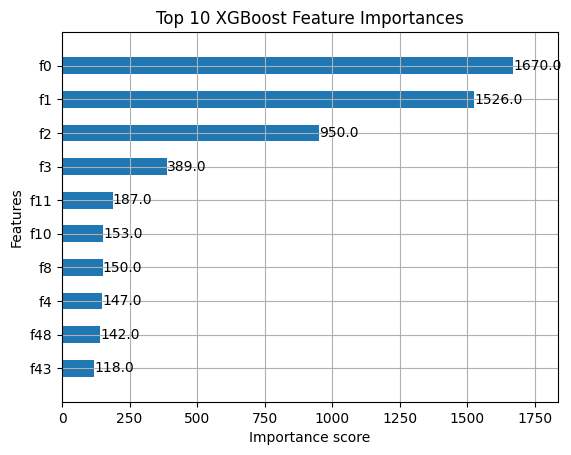

In [76]:
xgb.plot_importance(xgb_model, max_num_features=10, height=0.5)
plt.title("Top 10 XGBoost Feature Importances")
plt.show()
